In [ ]:

from google.colab import drive
drive.mount('/content/drive')


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os

Mounted at /content/drive


In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

Đang sử dụng thiết bị: cuda:0


In [ ]:
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter

data_dir = '/content/drive/MyDrive/DeepLearning/data'

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

temp_dataset = datasets.ImageFolder(data_dir)
targets = np.array(temp_dataset.targets)
class_counts = Counter(targets)
single_sample_classes = [cls for cls, count in class_counts.items() if count < 2]
multi_sample_mask = ~np.isin(targets, single_sample_classes)
multi_sample_indices = np.where(multi_sample_mask)[0]
multi_sample_targets = targets[multi_sample_mask]
single_sample_indices = np.where(~multi_sample_mask)[0]

if len(multi_sample_indices) > 0 and len(np.unique(multi_sample_targets)) > 1:
    train_multi_idx, test_idx = train_test_split(
        multi_sample_indices,
        test_size=0.3,
        random_state=42,
        stratify=multi_sample_targets
    )
else:

    print("Warning: Không đủ dữ liệu cho stratified split sau khi lọc các lớp đơn lẻ. Thực hiện chia không stratified.")
    train_multi_idx, test_idx = train_test_split(
        np.arange(len(temp_dataset)),
        test_size=0.3,
        random_state=42
    )


if len(single_sample_indices) > 0:
    print(f"Cảnh báo: Có {len(single_sample_classes)} lớp chỉ có 1 mẫu, các mẫu này đã được thêm hoàn toàn vào tập huấn luyện.")
    train_idx = np.concatenate((train_multi_idx, single_sample_indices))
else:
    train_idx = train_multi_idx



train_dataset = Subset(datasets.ImageFolder(data_dir, transform=train_transforms), train_idx)
test_dataset = Subset(datasets.ImageFolder(data_dir, transform=test_transforms), test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Tổng số ảnh ban đầu: {len(temp_dataset)}")
print(f"Train size (có Augmentation): {len(train_dataset)}")
print(f"Test size (nguyên bản): {len(test_dataset)}")
print(f"Số lượng nhãn: {len(temp_dataset.classes)}")

Cảnh báo: Có 1 lớp chỉ có 1 mẫu, các mẫu này đã được thêm hoàn toàn vào tập huấn luyện.
Tổng số ảnh ban đầu: 583
Train size (có Augmentation): 408
Test size (nguyên bản): 175
Số lượng nhãn: 30


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init

class Fire(nn.Module):
    def __init__(self, inplanes, squeeze_planes, expand1x1_planes, expand3x3_planes):
        super(Fire, self).__init__()


        self.squeeze = nn.Conv2d(inplanes, squeeze_planes, kernel_size=1)
        self.squeeze_activation = nn.ReLU(inplace=True)


        self.expand1x1 = nn.Conv2d(squeeze_planes, expand1x1_planes, kernel_size=1)
        self.expand1x1_activation = nn.ReLU(inplace=True)


        self.expand3x3 = nn.Conv2d(squeeze_planes, expand3x3_planes, kernel_size=3, padding=1)
        self.expand3x3_activation = nn.ReLU(inplace=True)

    def forward(self, x):

        x = self.squeeze_activation(self.squeeze(x))


        branch1 = self.expand1x1_activation(self.expand1x1(x))
        branch2 = self.expand3x3_activation(self.expand3x3(x))


        return torch.cat([branch1, branch2], 1)
class MySqueezeNet(nn.Module):
    def __init__(self, num_classes=30):
        super(MySqueezeNet, self).__init__()

        self.num_classes = num_classes


        self.features = nn.Sequential(

            nn.Conv2d(3, 64, kernel_size=3, stride=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),


            Fire(64, 16, 64, 64),
            Fire(128, 16, 64, 64),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),

            Fire(128, 32, 128, 128),
            Fire(256, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2, ceil_mode=True),

            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            Fire(512, 64, 256, 256),
        )


        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),


            nn.Conv2d(512, self.num_classes, kernel_size=1),
            nn.ReLU(inplace=True),


            nn.AdaptiveAvgPool2d((1, 1))
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_uniform_(m.weight)
                if m.bias is not None:
                    init.constant_(m.bias, 0)

    def forward(self, x):

        x = self.features(x)

        x = self.classifier(x)

        return torch.flatten(x, 1)
model = MySqueezeNet(num_classes=30)

model = model.to(device)


In [ ]:
print(model)

MySqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 160

print("Bắt đầu huấn luyện...")

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = train_correct / train_total
    train_loss = running_loss / train_total

    # --- GIAI ĐOẠN 2: TEST (EVALUATION) ---
    model.eval() # Chế độ đánh giá (tắt dropout, v.v.)
    test_correct = 0
    test_total = 0

    # Không tính gradient khi test để tiết kiệm bộ nhớ
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total


    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'   Test Acc:  {test_acc:.4f}  <-- Độ chính xác thực tế trên tập kiểm tra')


print("Huấn luyện hoàn tất!")

torch.save(model.state_dict(), '/content/drive/MyDrive/DeepLearning/face_recognition.pth')

Bắt đầu huấn luyện...
Epoch 1/50:
   Train Loss: 3.4682 | Train Acc: 0.0294
   Test Acc:  0.0400  <-- Độ chính xác thực tế trên tập kiểm tra


KeyboardInterrupt: 

Bắt đầu huấn luyện...
Epoch 1/160:
   Train Loss: 3.5771 | Train Acc: 0.0343
   Test Acc:  0.0343
Epoch 2/160:
   Train Loss: 3.4059 | Train Acc: 0.0319
   Test Acc:  0.0514
Epoch 3/160:
   Train Loss: 3.3993 | Train Acc: 0.0368
   Test Acc:  0.0343
Epoch 4/160:
   Train Loss: 3.3921 | Train Acc: 0.0343
   Test Acc:  0.0343
Epoch 5/160:
   Train Loss: 3.3525 | Train Acc: 0.0564
   Test Acc:  0.0571
Epoch 6/160:
   Train Loss: 3.3517 | Train Acc: 0.0735
   Test Acc:  0.0571
Epoch 7/160:
   Train Loss: 3.3435 | Train Acc: 0.0711
   Test Acc:  0.0743
Epoch 8/160:
   Train Loss: 3.3221 | Train Acc: 0.0686
   Test Acc:  0.0800
Epoch 9/160:
   Train Loss: 3.3490 | Train Acc: 0.0711
   Test Acc:  0.0800
Epoch 10/160:
   Train Loss: 3.3608 | Train Acc: 0.0588
   Test Acc:  0.0686
Epoch 11/160:
   Train Loss: 3.2956 | Train Acc: 0.0760
   Test Acc:  0.0857
Epoch 12/160:
   Train Loss: 3.2618 | Train Acc: 0.0907
   Test Acc:  0.1029
Epoch 13/160:
   Train Loss: 3.2156 | Train Acc: 0.0858
   Test

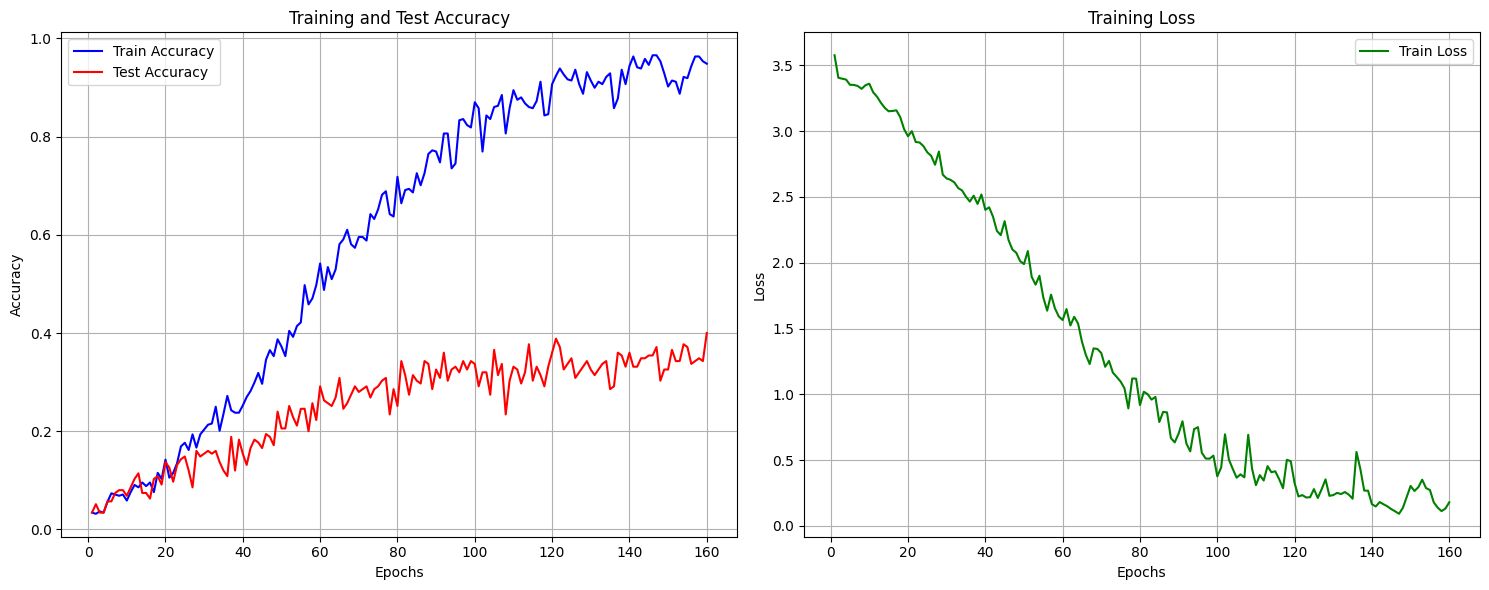

In [ ]:
import matplotlib.pyplot as plt

# 1. Khởi tạo các list để lưu lịch sử huấn luyện
train_loss_history = []
train_acc_history = []
test_acc_history = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 160

print("Bắt đầu huấn luyện...")

for epoch in range(num_epochs):
    # --- GIAI ĐOẠN 1: TRAIN ---
    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = train_correct / train_total
    train_loss = running_loss / train_total

    # --- GIAI ĐOẠN 2: TEST (EVALUATION) ---
    model.eval()
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total

    # --- QUAN TRỌNG: LƯU LẠI KẾT QUẢ VÀO LIST ---
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'   Test Acc:  {test_acc:.4f}')

print("Huấn luyện hoàn tất!")

# ============================================================
# HÀM VẼ ĐỒ THỊ
# ============================================================
def plot_training_results(train_acc, test_acc, train_loss):
    epochs = range(1, len(train_acc) + 1)

    # Tạo khung hình lớn kích thước 15x6 inch
    plt.figure(figsize=(15, 6))

    # --- BIỂU ĐỒ 1: SO SÁNH ACCURACY ---
    plt.subplot(1, 2, 1) # Vị trí bên trái
    plt.plot(epochs, train_acc, 'b-', label='Train Accuracy')
    plt.plot(epochs, test_acc, 'r-', label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True) # Thêm lưới cho dễ nhìn

    # --- BIỂU ĐỒ 2: TRAIN LOSS ---
    plt.subplot(1, 2, 2) # Vị trí bên phải
    plt.plot(epochs, train_loss, 'g-', label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Hiển thị biểu đồ
    plt.tight_layout()
    plt.show()

# Gọi hàm vẽ đồ thị
plot_training_results(train_acc_history, test_acc_history, train_loss_history)

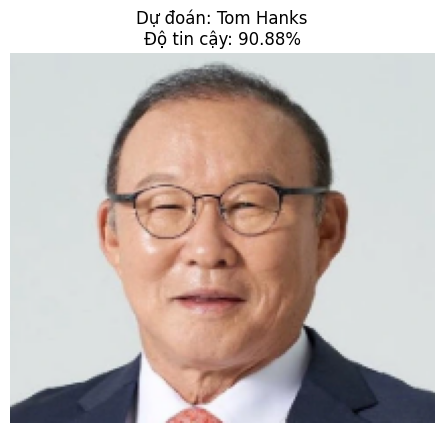

Model nhận diện đây là: Tom Hanks (Tỉ lệ: 90.88%)


In [ ]:
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Lấy danh sách tên các lớp từ dataset đã load trước đó
class_names = temp_dataset.classes

# --- ĐƯỜNG DẪN ẢNH BẠN MUỐN KIỂM TRA ---
# Bạn thay đường dẫn này bằng đường dẫn file ảnh bất kỳ trong drive của bạn
# Mẹo: Chuột phải vào file ảnh ở cột bên trái Colab -> chọn "Copy path"
img_path_to_check = '/content/drive/MyDrive/DeepLearning/anh6.png'

def predict_immediate(path):
    # 1. Chuyển model sang chế độ đánh giá (quan trọng)
    model.eval()

    # 2. Xử lý ảnh giống hệt lúc Test (Resize -> Tensor -> Normalize)
    # Ta dùng lại các thông số chuẩn hóa như lúc train
    process_img = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:
        # Mở ảnh và xử lý
        img = Image.open(path).convert('RGB')
        img_tensor = process_img(img).unsqueeze(0) # Thêm 1 chiều batch thành [1, 3, 224, 224]
        img_tensor = img_tensor.to(device)

        # 3. Dự đoán
        with torch.no_grad():
            outputs = model(img_tensor)
            probs = F.softmax(outputs, dim=1) # Chuyển thành xác suất %
            confidence, idx = torch.max(probs, 1) # Lấy nhãn có xác suất cao nhất

        # 4. Hiển thị kết quả
        pred_label = class_names[idx.item()]
        conf_score = confidence.item() * 100

        # Vẽ ảnh và ghi chú thích
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Dự đoán: {pred_label}\nĐộ tin cậy: {conf_score:.2f}%")
        plt.show()

        print(f"Model nhận diện đây là: {pred_label} (Tỉ lệ: {conf_score:.2f}%)")

    except FileNotFoundError:
        print("Lỗi: Không tìm thấy file ảnh. Bạn kiểm tra lại đường dẫn nhé.")

# Chạy hàm
predict_immediate(img_path_to_check)

In [ ]:

model = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.DEFAULT)

for param in model.features.parameters():
    param.requires_grad = False

num_classes = 30
in_channels = 512


model.classifier[1] = nn.Conv2d(in_channels, num_classes, kernel_size=(1,1))

model = model.to(device)

print("Cấu trúc mạng sau khi sửa đổi:")
print(model.classifier)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

num_epochs = 20

print("Bắt đầu huấn luyện...")

for epoch in range(num_epochs):

    model.train()
    running_loss = 0.0
    train_correct = 0
    train_total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_acc = train_correct / train_total
    train_loss = running_loss / train_total


    model.eval()
    test_correct = 0
    test_total = 0


    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_acc = test_correct / test_total

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'   Test Acc:  {test_acc:.4f}  <-- Độ chính xác thực tế trên tập kiểm tra')

print("Huấn luyện hoàn tất!")
torch.save(model.state_dict(), '/content/drive/MyDrive/face_recognition_squeezenet_split.pth')

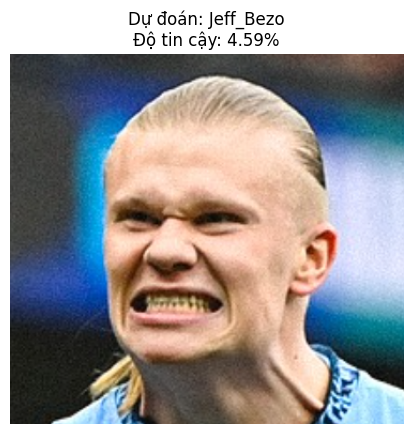

Model nhận diện đây là: Jeff_Bezo (Tỉ lệ: 4.59%)


In [ ]:
from PIL import Image
import torch.nn.functional as F
import matplotlib.pyplot as plt

class_names = temp_dataset.classes


img_path_to_check = '/content/drive/MyDrive/DeepLearning/anh5.png'

def predict_immediate(path):

    model.eval()
    process_img = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    try:

        img = Image.open(path).convert('RGB')
        img_tensor = process_img(img).unsqueeze(0)
        img_tensor = img_tensor.to(device)

        with torch.no_grad():
            outputs = model(img_tensor)
            probs = F.softmax(outputs, dim=1)
            confidence, idx = torch.max(probs, 1)


        pred_label = class_names[idx.item()]
        conf_score = confidence.item() * 100


        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Dự đoán: {pred_label}\nĐộ tin cậy: {conf_score:.2f}%")
        plt.show()

        print(f"Model nhận diện đây là: {pred_label} (Tỉ lệ: {conf_score:.2f}%)")

    except FileNotFoundError:
        print("Lỗi: Không tìm thấy file ảnh. Bạn kiểm tra lại đường dẫn nhé.")


predict_immediate(img_path_to_check)